In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('magma')
import numpy as np

plt.style.use('aa_paper')
%matplotlib inline

gene = 'PCSK9'
gene_lower = gene.lower()
chrom = 'chr1'
start = 55040221
end = 55064853

Note: this notebook relies on the Jupyter extension [Python Markdown](https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tree/master/src/jupyter_contrib_nbextensions/nbextensions/python-markdown) to properly display the commands below, and in other markdown cells. 

This notebook describes our process of designing optimal guides for allele-specific excision for the gene *{{gene}}*. *{{gene}}* is a gene located on {{chrom}}.

# Identify variants to target 

Identify exhaustive list of targetable variant pairs in the gene with 1000 Genomes data for excision maximum limit = 10kb for the paper.

`python ~/projects/AlleleAnalyzer/scripts/ExcisionFinder.py -v /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/1000genomes_analysis/get_gene_list/gene_list_hg38.tsv {{gene}} /pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg38_analysis/1kgp_annotated_variants_by_chrom/{{chrom}}_annotated.h5 10000 SpCas9,SaCas9 /pollard/data/genetics/1kg/phase3/hg38/ALL.{{chrom}}_GRCh38.genotypes.20170504.bcf /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_var_pairs_ --window=5000 --exhaustive`

## Generate arcplot input for all populations together and for each superpopulation.

`python ~/projects/AlleleAnalyzer/plotting_scripts/gen_arcplot_input.py /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_var_pairs_exh.tsv /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_arcplot_ALL`

`parallel " python ~/projects/AlleleAnalyzer/plotting_scripts/gen_arcplot_input.py /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_var_pairs_exh.tsv /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_arcplot_{} --sample_legend=/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/1kg_allsamples.tsv --pop={} " ::: AFR AMR EAS EUR SAS`

### Plot arcplots together to demonstrate the different patterns of sharing.

`python ~/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/src/superpops_for_arcplot_merged.py ~/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_arcplot_ ~/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_`

`Rscript ~/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/src/arcplot_superpops_for_paper.R ~/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_all_pops_arcplot_input.tsv ~/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_filt15_allpops 15 {{start}} {{end}} 5000 {{gene}}`

# Set Cover

## Use set cover to identify top 5 variant pairs

`python ~/projects/AlleleAnalyzer/scripts/optimize_ppl_covered.py --type=max_probes 5 ~/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_var_pairs_exh.tsv ~/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_set_cover_5_pairs`



In [2]:
set_cover_top_pairs = pd.read_csv(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/{gene_lower}_set_cover_5_pairs_pairs_used.txt',
                          sep='\t')

In [3]:
set_cover_top_pairs

,var1,var2
0,55038913,55039995
1,55052188,55052643
2,55055569,55056468
3,55058524,55058564
4,55059169,55059727


## Population coverage for set cover pairs

In [8]:
def ppl_covered(guides_used_df, cohort_df):
    guides_list = guides_used_df['var1'].tolist() + guides_used_df['var2'].tolist()
    ppl_covered = cohort_df.query('(var1 in @guides_list) and (var2 in @guides_list)').copy()
    return ppl_covered

In [9]:
global pairs_to_ppl
pairs_to_ppl = pd.read_csv(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/{gene_lower}_var_pairs_exh.tsv',
                          sep='\t', low_memory=False)

In [10]:
ptp_sc_5 = ppl_covered(set_cover_top_pairs, pairs_to_ppl)

In [11]:
ptp_sc_5.head()

,var1,var2,ind,targ_SpCas9,targ_SaCas9
100,55052643,55055569,HG00096,SpCas9,NaN
111,55052643,55058524,HG00096,SpCas9,NaN
112,55052643,55058564,HG00096,SpCas9,NaN
293,55055569,55058524,HG00096,SpCas9,NaN
294,55055569,55058564,HG00096,SpCas9,NaN


# Top 5

## Extract top 5 pairs by population coverage

In [12]:
top_five_top_pairs = pd.read_csv(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/{gene_lower}_arcplot_ALL.tsv',
                              sep='\t').sort_values(by='percent_pop_covered', ascending=False).head().reset_index(drop=True)

In [13]:
ptp_top_5 = ppl_covered(top_five_top_pairs[['var1','var2']], pairs_to_ppl)

Demonstrate the difference in population coverages between top 5 shared pairs and set cover identified pairs.

In [14]:
top_five_top_pairs

,var1,var2,n_inds,percent_pop_covered
0,55055569,55056468,909,36.301917
1,55059169,55059727,908,36.261981
2,55054539,55056468,907,36.222045
3,55054735,55056468,894,35.702875
4,55055436,55056468,889,35.503195


# Make arcplots for set cover and top 5 pairs

Make file of set cover pairs for use with arcplot plotting script.

In [15]:
# set cover

exh = pd.read_csv(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/{gene_lower}_var_pairs_exh.tsv',
                 sep='\t', low_memory=False)

exh_sc = []

for ix, row in set_cover_top_pairs.iterrows():
    var1 = row['var1']
    var2 = row['var2']
    exh_sc.append(pd.DataFrame(exh.query('(var1 == @var1) and (var2 == @var2)')))
    
exh_sc_df = pd.concat(exh_sc)

exh_sc_df.to_csv(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/{gene_lower}_var_pairs_exh_sc.tsv',
                sep='\t', index=False)

In [16]:
# top 5

exh = pd.read_csv(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/{gene_lower}_var_pairs_exh.tsv',
                 sep='\t', low_memory=False)

exh_tf = []

for ix, row in top_five_top_pairs.iterrows():
    var1 = row['var1']
    var2 = row['var2']
    exh_tf.append(pd.DataFrame(exh.query('(var1 == @var1) and (var2 == @var2)')))
    
exh_tf_df = pd.concat(exh_tf)

exh_tf_df.to_csv(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/{gene_lower}_var_pairs_exh_tf.tsv',
                sep='\t', index=False)

### Set cover

Make input arcplot-formatted:

`python ~/projects/AlleleAnalyzer/plotting_scripts/gen_arcplot_input.py /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_var_pairs_exh_sc.tsv /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_arcplot_set_cover_ALL`

Make arcplot:

`Rscript ~/projects/AlleleAnalyzer/plotting_scripts/arcplot_generic.R /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_arcplot_set_cover_ALL.tsv /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_arcplot_set_cover_ALL 0 {{start}} {{end}} 5000 {{gene}}`

### Top 5

Make input arcplot-formatted:

`python ~/projects/AlleleAnalyzer/plotting_scripts/gen_arcplot_input.py /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_var_pairs_exh_tf.tsv /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_arcplot_top_five_ALL`

Make arcplot:

`Rscript ~/projects/AlleleAnalyzer/plotting_scripts/arcplot_generic.R /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_arcplot_top_five_ALL.tsv /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/{{gene_lower}}_arcplot_top_five_ALL 0 {{start}} {{end}} 5000 {{gene}}`

# Compare coverage

Text(0.5, 1.0, 'AlleleAnalyzer')

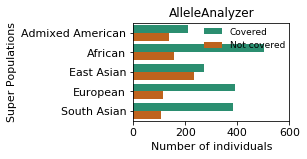

In [17]:
def cov_cat(row):
    if row['sample'] in ptp_top_5['ind'].tolist() and row['sample'] in ptp_sc_5['ind'].tolist():
        return 'Both'
    elif row['sample'] in ptp_top_5['ind'].tolist():
        return 'Top 5'
    elif row['sample'] in ptp_sc_5['ind'].tolist():
        return 'Set Cover'
    else:
        return 'Neither'
global inds
inds = pd.read_csv('/pollard/data/projects/AlleleAnalyzer_data/1kgp_data/1kg_allsamples.tsv',
                  sep='\t')
inds_cov = inds.copy()
inds_cov['AlleleAnalyzer'] = inds['sample'].isin(ptp_sc_5['ind'])
inds_cov['Top 5'] = inds['sample'].isin(ptp_top_5['ind'])
inds_cov['Coverage'] = inds_cov.apply(lambda row: cov_cat(row), axis=1)

global superpop_dict
superpop_dict = {
    'AMR':'Admixed American',
    'AFR':'African',
    'SAS':'South Asian',
    'EAS':'East Asian',
    'EUR':'European'
}

sns.set_palette('Dark2', n_colors=3)
fig, ax = plt.subplots(figsize=(2.8, 1.8))
sns.countplot(y='superpop', hue='AlleleAnalyzer', data=inds_cov.replace(superpop_dict).replace({
    True:'Covered',
    False:'Not covered'
}).sort_values(by=['superpop','Coverage']))
plt.xlabel('Number of individuals')
plt.ylabel('Super Populations')
plt.xticks(rotation=0)
ax.legend(loc='upper right',prop={'size': 9},
         frameon=False,
         borderaxespad=0.1)
ax.set_xlim([0,600]) # 600 often works but can be tweaked per gene
plt.title('AlleleAnalyzer')

Text(0.5, 1.0, 'Top 5')

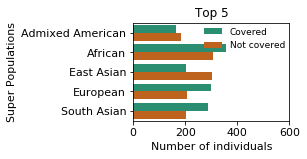

In [18]:
sns.set_palette('Dark2', n_colors=3)
fig, ax = plt.subplots(figsize=(2.8, 1.8))
sns.countplot(y='superpop', hue='Top 5', data=inds_cov.replace(superpop_dict).replace({
    True:'Covered',
    False:'Not covered'
}).sort_values(by=['superpop','Coverage']))
plt.xlabel('Number of individuals')
plt.ylabel('Super Populations')
plt.xticks(rotation=0)
ax.legend(loc='upper right',prop={'size': 9},
         frameon=False,
         borderaxespad=0.1)
ax.set_xlim([0,600]) # 600 often works but can be tweaked per gene
plt.title('Top 5')

# Design and score sgRNAs for variants included in Set Cover and Top 5 pairs

## Set Cover
### Make BED files for positions for each variant pair

In [19]:
set_cover_bed = pd.DataFrame() 
set_cover_bed['start'] = set_cover_top_pairs['var1'].tolist() + set_cover_top_pairs['var2'].tolist()
set_cover_bed['end'] = set_cover_top_pairs['var1'].tolist() + set_cover_top_pairs['var2'].tolist()
set_cover_bed['region'] = set_cover_bed.index
set_cover_bed['chrom'] = f'{chrom}'

set_cover_bed = set_cover_bed[['chrom','start','end','region']]
set_cover_bed.to_csv(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/set_cover_pairs.bed',
                    sep='\t', index=False, header=False)

### Design sgRNAs

`python ~/projects/AlleleAnalyzer/scripts/gen_sgRNAs.py -v /pollard/data/genetics/1kg/phase3/hg38/ALL.{{chrom}}_GRCh38.genotypes.20170504.bcf /pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg38_analysis/1kgp_annotated_variants_by_chrom/{{chrom}}_annotated.h5 /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/set_cover_pairs.bed /pollard/data/projects/AlleleAnalyzer_data/pam_sites_hg38/ /pollard/data/vertebrate_genomes/human/hg38/hg38/hg38.fa /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/guides_set_cover_{{gene_lower}} SpCas9,SaCas9 20 --bed --sim -d --crispor=hg38`

## Top 5
### Make BED files for positions for each variant pair

In [20]:
top_five_bed = pd.DataFrame() 
top_five_bed['start'] = top_five_top_pairs['var1'].tolist() + top_five_top_pairs['var2'].tolist()
top_five_bed['end'] = top_five_top_pairs['var1'].tolist() + top_five_top_pairs['var2'].tolist()
top_five_bed['region'] = top_five_bed.index
top_five_bed['chrom'] = f'{chrom}'

top_five_bed = top_five_bed[['chrom','start','end','region']]
top_five_bed.to_csv(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/top_five_pairs.bed',
                    sep='\t', index=False, header=False)



### Design sgRNAs

`python ~/projects/AlleleAnalyzer/scripts/gen_sgRNAs.py -v /pollard/data/genetics/1kg/phase3/hg38/ALL.{{chrom}}_GRCh38.genotypes.20170504.bcf /pollard/data/projects/AlleleAnalyzer_data/1kgp_data/hg38_analysis/1kgp_annotated_variants_by_chrom/{{chrom}}_annotated.h5 /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/top_five_pairs.bed /pollard/data/projects/AlleleAnalyzer_data/pam_sites_hg38/ /pollard/data/vertebrate_genomes/human/hg38/hg38/hg38.fa /pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{{gene}}/guides_top_five_{{gene_lower}} SpCas9,SaCas9 20 --bed --sim -d --crispor=hg38`

# Reanalyze coverage at positions with at least 1 sgRNA with predicted specificity score > threshold

## Set Cover

In [21]:
sc_grnas = pd.read_csv(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/guides_set_cover_{gene_lower}.tsv',
                      sep='\t')

def get_pairs(pairs_df, grna_df, min_score=0):
    grna_df_spec = grna_df.query('(scores_ref >= @min_score) or (scores_alt >= @min_score)')
    positions = grna_df_spec['variant_position'].astype(int).unique().tolist()
    pairs_out = pairs_df.query('(var1 in @positions) and (var2 in @positions)').copy()
    return(pairs_out)

def plot_coverage(orig_pairs, grnas, min_score_list, xlim, legend_pos='lower right', sc=True):
    if sc:
        label = 'AlleleAnalyzer'
    else:
        label = 'Top 5'
    
    inds_cov_df_list = []
    for min_score in min_score_list:
        pairs_filt = get_pairs(orig_pairs, grnas, min_score = min_score)
        ptp = ppl_covered(pairs_filt, pairs_to_ppl)
        inds_cov = inds.copy()
        inds_cov['Coverage'] = inds['sample'].isin(ptp['ind'])
        inds_cov['Minimum Specificity Score'] = min_score
        inds_cov_df_list.append(inds_cov)
    
    inds_cov = pd.concat(inds_cov_df_list).query('Coverage').drop_duplicates()
    
    fig, ax = plt.subplots(figsize=(3.8, 5.8))
    p = sns.countplot(y='superpop', hue='Minimum Specificity Score', 
                      data=inds_cov.replace(superpop_dict).sort_values(by=['superpop']), palette='magma')
#     p = sns.catplot(y='superpop', hue='Minimum Specificity Score', kind='count', row='superpop',
#                       data=inds_cov.replace(superpop_dict).sort_values(by=['superpop']), palette='magma')
    plt.xlabel('Number of individuals')
    plt.ylabel('Super Populations')
#     plt.xticks(rotation=45)
    plt.legend(loc=legend_pos,prop={'size': 9},
         frameon=False,
         borderaxespad=0.1,
              title='Minimum score')
    ax.set_xlim([0,xlim])
    if sc:
        plt.title(f'AlleleAnalyzer coverage at various \nminimum score thresholds, {gene}')
    else:
        plt.title(f'Top 5 sites at various \nminimum score thresholds, {gene}')
    return p

In [22]:
set_cover_top_pairs.head()

,var1,var2
0,55038913,55039995
1,55052188,55052643
2,55055569,55056468
3,55058524,55058564
4,55059169,55059727


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

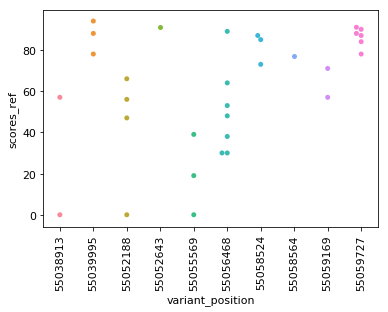

In [23]:
sns.swarmplot(x='variant_position', y='scores_ref', data=sc_grnas)
plt.xticks(rotation=90)

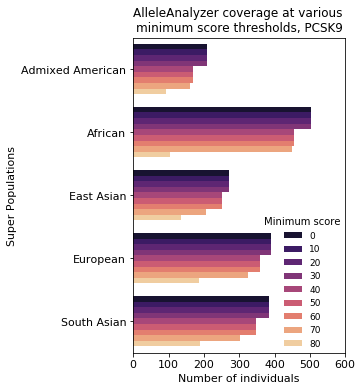

In [24]:
p = plot_coverage(set_cover_top_pairs, sc_grnas, list(range(0, 100, 10)), 600, 'lower right')

In [25]:
p.get_figure().savefig(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/sc_coverage_all.pdf',
                      dpi=300, bbox_inches='tight')

In [26]:
def plot_overall(orig_pairs, grnas, max_y):
    
    filters = list(range(0,100,10))

    plot_vals = {}

    for filt in filters:
        pairs_filt = get_pairs(orig_pairs, grnas, min_score = filt)
        ptp = ppl_covered(pairs_filt, pairs_to_ppl)
        plot_vals[filt] = 100.0* (len(ptp['ind'].unique())/2504.0)

    plot_vals_df = pd.DataFrame.from_dict(plot_vals, orient='index')
    plot_vals_df['Minimum Score'] = plot_vals_df.index
    plot_vals_df.columns = ['% 1KGP Covered','Minimum Score']
    
    fig, ax = plt.subplots(figsize=(3.8, 2.8))

    p = sns.barplot(x='Minimum Score', y='% 1KGP Covered', 
               data=plot_vals_df, palette='magma')
    plt.title(f'Overall 1KGP Coverage with Filtering\n by Predicted Specificity Score, {gene}')
    plt.xlabel('Minimum Score Threshold')
    ax.set_ylim([0,max_y])
    
    return(p)

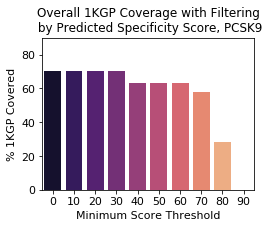

In [27]:
sc_overall_plot = plot_overall(set_cover_top_pairs, sc_grnas, 90)

In [28]:
sc_overall_plot.get_figure().savefig(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/1kgp_cov_overall_set_cover.pdf',
                                  dpi=300, bbox_inches='tight')

## Top 5

In [29]:
tf_grnas = pd.read_csv(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/guides_top_five_{gene_lower}.tsv',
                      sep='\t')

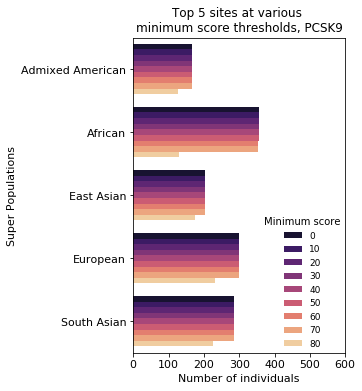

In [30]:
p = plot_coverage(top_five_top_pairs, tf_grnas, list(range(0, 100, 10)), 600, 'lower right', sc=False)

In [31]:
p.get_figure().savefig(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/tf_coverage_all.pdf',
                      dpi=300, bbox_inches='tight')

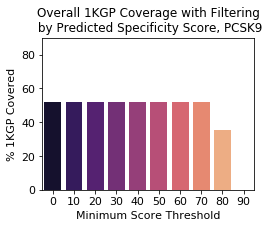

In [32]:
tf_overall_plot = plot_overall(top_five_top_pairs, tf_grnas, 90)

In [33]:
tf_overall_plot.get_figure().savefig(f'/pollard/home/kathleen/projects/AlleleAnalyzer/manuscript_analyses/set_cover_analysis/{gene}/1kgp_cov_overall_top_five.pdf',
                                  dpi=300, bbox_inches='tight')